# MSD Data Modeling
- Not the final work, but it's all based on this analysis
- The first part also writes the "dataModel.csv" for easier access to the data for modeling
- For the actual results, go to reg-sampling.ipynb
- This notebook can be used as a comparison for performance with and without sampling

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [269]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor

In [270]:
df = pd.read_csv("data/dataTotal.csv")

In [271]:
print(df.shape)
df.columns

(22606, 51)


Index(['SongNumber', 'SongID_x', 'AlbumID', 'AlbumName', 'ArtistID',
       'ArtistLatitude', 'ArtistLocation', 'ArtistLongitude', 'ArtistName',
       'Danceability', 'Duration', 'KeySignature', 'KeySignatureConfidence',
       'Tempo', 'TimeSignature', 'TimeSignatureConfidence', 'Title', 'Year',
       'song_hotttnesss', 'artist_hotttnesss', 'artist_mbtags',
       'artist_mbtags_count', 'SearchStr', 'market', 'SearchStr_nopar',
       'SearchStr_decode_nopar', 'SongID_y', 'SpotifySongTitle',
       'SpotifyArtistTitle', 'Popularity', 'SpotifySearchStr',
       'SpotifySearchStr_nopar', 'SpotifySearchStr_decode_nopar',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [272]:
## define cols to remove
## notes for Brian: we should keep Year, some search str (embedding?), good looks for removing duplicates
## keeping the Spotify "better" data
REMOVE_COLS = ['SongNumber', 'SongID_x', 'AlbumName', 'ArtistLatitude', 'ArtistLocation',
               'ArtistLongitude', 'type', 'id', 'uri', 'track_href', 'analysis_url',
               'artist_mbtags',
               'artist_mbtags_count','SearchStr','SearchStr_decode_nopar',
               'SearchStr_nopar','Danceability','KeySignature','TimeSignature',
               'Tempo','Duration','artist_hotttnesss','song_hotttnesss', 'market',
               'AlbumID','ArtistID','market']

## ^^ probably remove the market, since it doesn't have much to do with the song itself. It was just used for
## the initial retrieval. [done later in Brian's nb]

## removed 'SpotifyTitle' 'Title_y' 'ArtistName_y'

In [273]:
df = df.drop(REMOVE_COLS, axis=1)
df.columns

Index(['ArtistName', 'KeySignatureConfidence', 'TimeSignatureConfidence',
       'Title', 'Year', 'SongID_y', 'SpotifySongTitle', 'SpotifyArtistTitle',
       'Popularity', 'SpotifySearchStr', 'SpotifySearchStr_nopar',
       'SpotifySearchStr_decode_nopar', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [274]:
## rename the columns
df.rename(columns={"ArtistName_x": "ArtistName", "Title_x": "Title", "SongID_y":"SongID"}, inplace=True)

In [275]:
df.head(1)

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Title,Year,SongID,SpotifySongTitle,SpotifyArtistTitle,Popularity,SpotifySearchStr,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,STRATOVARIUS,0.838,0.256,Fire Dance,1989.0,3YOhXYCLFRQxEmUlzjiWEJ,Fire Dance,Stratovarius,17.0,fire dance stratovarius,...,-6.213,0.0,0.129,0.000709,0.892,0.0579,0.667,134.096,136933.0,4.0


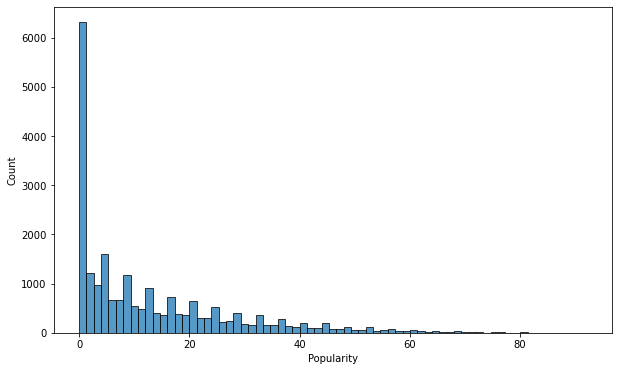

In [276]:
## Some EDA to see how we handle data
# How do we impute popularity, or do we not the entire entry if there is no popularity (there's a difference with it being 0 though)
# How can we maximize the variables we currently have: text vectorization? Minimize loss during testing

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=df, x="Popularity", cumulative=False ,ax=ax);

## notice there really aren't many songs that are high up (80-100)
# df

In [277]:
df.Popularity.value_counts()

0.0     4747
1.0     1566
2.0     1206
3.0      980
4.0      840
        ... 
77.0       3
84.0       2
83.0       1
82.0       1
92.0       1
Name: Popularity, Length: 86, dtype: int64

## Prepare Data for Modeling
- check out imputing, handling missing values
- using artist name as a numerical feature somehow?

In [278]:
df.dropna(subset=["Popularity"], inplace=True)

In [279]:
## make labels for artist name, prob an important feature
le = LabelEncoder()

df["ArtistName"] = le.fit_transform(df.ArtistName)
df.drop("Title", axis=1, inplace=True)
df.head()

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,SongID,SpotifySongTitle,SpotifyArtistTitle,Popularity,SpotifySearchStr,SpotifySearchStr_nopar,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10694,0.838,0.256,1989.0,3YOhXYCLFRQxEmUlzjiWEJ,Fire Dance,Stratovarius,17.0,fire dance stratovarius,fire dance stratovarius,...,-6.213,0.0,0.1290,0.000709,0.892000,0.0579,0.667,134.096,136933.0,4.0
1,4528,0.955,0.867,0.0,53RfjM48r9xNywpDiog6zG,Don't Worry,Fred Thomas,1.0,don't worry fred thomas,don't worry fred thomas,...,-13.728,1.0,0.0401,0.943000,0.106000,0.1220,0.506,76.672,256827.0,3.0
2,3297,0.056,0.748,0.0,73vcZCFNErwqHxuS1BXH0e,Intro/Love Line Interlude 1,Deviants Of Reality,0.0,intro/love line interlude 1 deviants of reality,intro/love line interlude 1 deviants of reality,...,-7.712,1.0,0.2490,0.077100,0.006890,0.2960,0.248,82.060,87800.0,4.0
3,4435,0.740,1.000,0.0,5V2GVAhUtjXwEfYNUjDUyz,Danny Boy,Foster & Allen,26.0,danny boy foster & allen,danny boy foster & allen,...,-9.781,1.0,0.0306,0.792000,0.167000,0.1160,0.278,170.527,205347.0,4.0
4,4319,0.673,0.582,0.0,0Qdy0Vu9xir8mjc6iQ6vTA,Postcard,Finn's Motel,0.0,postcard finn's motel,postcard finn's motel,...,-11.859,1.0,0.0987,0.330000,0.000009,0.7180,0.087,138.553,101947.0,4.0


In [283]:
# need to drop the object types, only use numbers for the data
drop_these = ["SongID", "SpotifySongTitle", "SpotifyArtistTitle", "SpotifySearchStr",
              "SpotifySearchStr_nopar", "SpotifySearchStr_decode_nopar"]
df = df.drop(drop_these, axis=1)

In [284]:
df

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10694,0.838,0.256,1989.0,17.0,0.537,0.810,8.0,-6.213,0.0,0.1290,0.000709,0.892000,0.0579,0.6670,134.096,136933.0,4.0
1,4528,0.955,0.867,0.0,1.0,0.342,0.377,11.0,-13.728,1.0,0.0401,0.943000,0.106000,0.1220,0.5060,76.672,256827.0,3.0
2,3297,0.056,0.748,0.0,0.0,0.663,0.614,2.0,-7.712,1.0,0.2490,0.077100,0.006890,0.2960,0.2480,82.060,87800.0,4.0
3,4435,0.740,1.000,0.0,26.0,0.163,0.262,1.0,-9.781,1.0,0.0306,0.792000,0.167000,0.1160,0.2780,170.527,205347.0,4.0
4,4319,0.673,0.582,0.0,0.0,0.262,0.753,9.0,-11.859,1.0,0.0987,0.330000,0.000009,0.7180,0.0870,138.553,101947.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22601,4799,0.457,1.000,2007.0,13.0,0.587,0.859,7.0,-4.793,1.0,0.0619,0.035800,0.000000,0.0561,0.4800,153.062,229693.0,4.0
22602,5605,0.046,0.043,1993.0,18.0,0.367,0.646,3.0,-8.317,0.0,0.1310,0.007320,0.000070,0.3600,0.6710,137.069,102867.0,4.0
22603,7480,0.288,1.000,2000.0,0.0,0.526,0.791,1.0,-3.553,1.0,0.4280,0.035600,0.000000,0.0560,0.5760,94.553,208600.0,4.0
22604,1251,0.107,0.428,2005.0,29.0,0.197,0.974,6.0,-4.609,0.0,0.2070,0.000009,0.731000,0.4020,0.0963,151.271,372053.0,4.0


In [285]:
## temporary write to have a easily accessible dataModel.csv for modeling
# df.to_csv("data/dataModel.csv", index=False)

## with this data, run the PCA notebook ***
## thhen run stuff below.

## Data Modeling
- Separate data into x, Y
- impute data, handle categorical features
- Think about binning popularity scores, creating a label for that and re-framing the problem into one of classification
- Regression evaluation: R2, MAE, RMSE

In [286]:
df = pd.read_csv("data/DataModelPCA+KMeans.csv")
df.columns

df = df.drop(['component1',
       'component2', 'component3', 'component4', 'component5', 'component6',
       'component7', 'component8', 'component9', 'component10', 'component11',
       'component12', 'component13', 'component14'], axis=1)

# df = df[['component1',
#        'component2', 'component3', 'component4', 'component5', 'component6',
#        'component7', 'component8', 'component9', 'component10', 'component11',
#        'component12', 'component13', 'component14', 'segment', 'Popularity']]

df

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,segment,Popularity
0,10694,0.838,0.256,1989.0,0.537,0.810,8.0,-6.213,0.0,0.1290,0.000709,0.892000,0.0579,0.6670,134.096,136933.0,4.0,8,17.0
1,4528,0.955,0.867,0.0,0.342,0.377,11.0,-13.728,1.0,0.0401,0.943000,0.106000,0.1220,0.5060,76.672,256827.0,3.0,6,1.0
2,3297,0.056,0.748,0.0,0.663,0.614,2.0,-7.712,1.0,0.2490,0.077100,0.006890,0.2960,0.2480,82.060,87800.0,4.0,4,0.0
3,4435,0.740,1.000,0.0,0.163,0.262,1.0,-9.781,1.0,0.0306,0.792000,0.167000,0.1160,0.2780,170.527,205347.0,4.0,2,26.0
4,4319,0.673,0.582,0.0,0.262,0.753,9.0,-11.859,1.0,0.0987,0.330000,0.000009,0.7180,0.0870,138.553,101947.0,4.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22595,4799,0.457,1.000,2007.0,0.587,0.859,7.0,-4.793,1.0,0.0619,0.035800,0.000000,0.0561,0.4800,153.062,229693.0,4.0,3,6.0
22596,5605,0.046,0.043,1993.0,0.367,0.646,3.0,-8.317,0.0,0.1310,0.007320,0.000070,0.3600,0.6710,137.069,102867.0,4.0,8,2.0
22597,7480,0.288,1.000,2000.0,0.526,0.791,1.0,-3.553,1.0,0.4280,0.035600,0.000000,0.0560,0.5760,94.553,208600.0,4.0,3,52.0
22598,1251,0.107,0.428,2005.0,0.197,0.974,6.0,-4.609,0.0,0.2070,0.000009,0.731000,0.4020,0.0963,151.271,372053.0,4.0,8,20.0


In [287]:
X = df.drop(['Popularity'], axis=1)
## for now, drop the categorical features here, and other ones we don't need
# X.drop(["ArtistName", "Title"], axis=1, inplace=True)
feature_names = X.columns.values
print("X shape:", X.shape)

y = df.Popularity

X shape: (22600, 18)


In [288]:
## what needs to probably be imputed? : year (neighbors), rest with Brian approach

imp = IterativeImputer(n_nearest_features=10)
X = imp.fit_transform(X)


In [289]:
# kmeans = KMeans(n_clusters=4, random_state=699).fit(StandardScaler().fit_transform(X))
# df["kmeans"] = kmeans.labels_ #len(kmeans.labels_)
# df.groupby("kmeans").describe()["Popularity"]

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=699)
## there's only one nan value for all song feature data for a song (Natasha Bedingfield)

### Dummy Regressor

In [291]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [292]:
dummy_train_r2 = dummy_reg.score(X_train, y_train)
dummy_test_r2 = dummy_reg.score(X_test, y_test)
dummy_preds = dummy_reg.predict(X_test)

dummy_RMSE = np.sqrt(mean_squared_error(y_test, dummy_preds))
dummy_MAE = mean_absolute_error(y_test, dummy_preds)

In [293]:
print(f'train r2: {dummy_train_r2}')
print(f'test r2: {dummy_test_r2}')
print(f'mae: {dummy_MAE}')
print(f'rmse: {dummy_RMSE}')
print(f'mse: {mean_squared_error(y_test, dummy_preds)}')


train r2: 0.0
test r2: -1.0033187325397819e-07
mae: 11.799959570052472
rmse: 15.191525536284741
mse: 230.78244811959138


Interesting results thus far. Regression seems like the way to go but because of the high density of
0 scores in the data, it might be worth creating labels depending on the range of the Popularity (that is,
the distribution of popularity scores in our final dataset). That way we pivot into a classification project
and sort of using MAE of ~12 the delta between the different bins.

Or maybe not. But let's continue with creating a tighter pipeline to test models/regressors

## Linear Regression, Random Forest, XGBoost: Initial Feature Importances


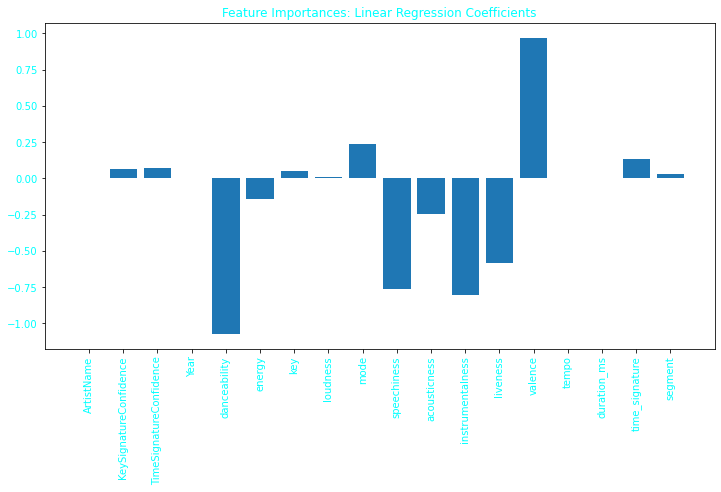

In [294]:
lr = LinearRegression().fit(X_train, y_train)

# get the feature names and coefficients
lr_feats = list(zip(feature_names, lr.coef_))
# print(feats)

fig, ax = plt.subplots(figsize=(12,6))
plt.bar([x[0] for x in lr_feats], [x[1] for x in lr_feats])

plt.title("Feature Importances: Linear Regression Coefficients", color='cyan')
plt.yticks(color="cyan")
plt.xticks(rotation=90, color="cyan");

In [296]:
%%time
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

CPU times: user 23.2 s, sys: 218 ms, total: 23.4 s
Wall time: 23.8 s


RandomForestRegressor()

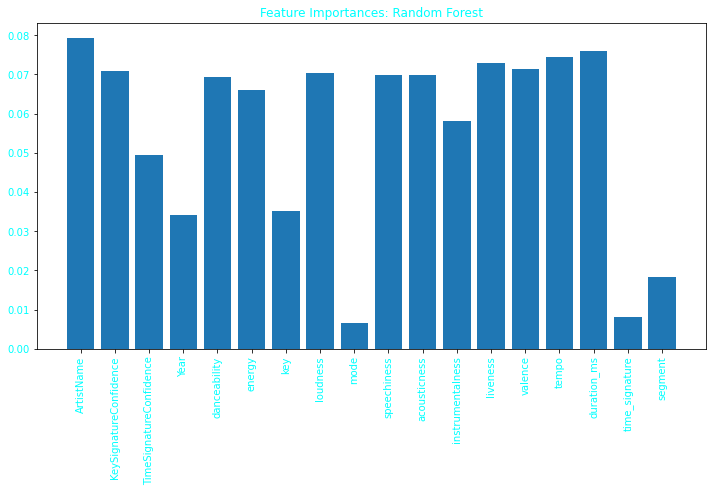

In [297]:
rf_feats = rf.feature_importances_

fig, ax = plt.subplots(figsize=(12,6))
plt.bar(feature_names, rf_feats)

plt.title("Feature Importances: Random Forest", color='cyan')
plt.yticks(color="cyan")
plt.xticks(rotation=90, color="cyan");

# df["component5"]

## Model Pipeline
- Linear Regression
- Ridge
- Lasso
- Random Forest Regression
- SVR (best thus far)
- XGBoost Regression
- AdaBoost Regressor

In [423]:
## Let's prepare a pipeline for testing
pipe = Pipeline([
    ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=10)),
    # ('poly', PolynomialFeatures(degree=2)),
    ('reg', MLPRegressor(alpha=2))])

# {'reg__learning_rate': 'optimal', 'reg__loss': 'huber', 'reg__penalty': 'l2'})


# ('reg', XGBRegressor(objective="reg:squarederror", eval_metric="rmse",
#                      gamma=0.3, max_depth=2, min_child_weight=5, subsample=1.0))
# pipe.fit(X_train, y_train)

In [424]:
#PCA=14, -12.0617, very flat predictions
params_LinReg = {}

# PCA=14, 'lad', -11.4445; after gridsearch: -11.4029, very flat predictions again
params_GBR = {'reg__loss': ["lad", "ls"],
              'reg__min_samples_split': [2, 4, 5],
              'reg__max_depth': [3, 5, 7],
              'reg__max_features': [None, 'auto', 'sqrt', 'log2']}

#PCA=14, -12.0978
params_Ridge = {}

#PCA=14, -12.4048
params_Lasso = {}

#PCA=14, -11.3711; after gridsarch: -11.3713, very flat predictions
params_LSVR = {'reg__C': [1.0, 3.0, 5.0],
               'reg__loss': ["epsilon_insensitive", "squares_epsilon_insensitive"],
               'reg__intercept_scaling': [1,2,3],
               'reg__dual': [True, False]}

#PCA=14, -14.8488, same after GS
params_Ada = {'reg__loss': ['linear', 'exponential', 'square']}

#PCA=14, -12.1329; after GS: -11.3837
params_SGD = {'reg__loss': ["huber", "squared_loss"],
              'reg__penalty': ["l1", "l2", "elasticnet"],
              'reg__learning_rate': ["invscaling", "optimal"]}

#PCA=14, -12.8717; after GS: -12.2040
params_XGB = {'reg__objective': ["reg:squarederror", "reg:linear"],
              'reg__eval_metric': ["mae", "rmse"],
              'reg__min_child_weight': [2,4,5],
              'reg__gamma':[i/10.0 for i in range(3,6)],
              'reg__subsample':[i/10.0 for i in range(6,11)],
              'reg__colsample_bytree':[i/10.0 for i in range(6,11)],
              'reg__max_depth': [2,3,4]}

#PCA=14, relu, -12.16; after GS: -12.0489
params_MLP = {'reg__activation': ['relu', 'tanh', 'linear', 'sigmoid'],
              'reg__hidden_layer_sizes': [(100,50,25), (150,100, 50, 30, 10), (100,), (150, 50, 2)],
              'reg__solver': ["sgd", "adam"],
              'reg__alpha': [0.0001, 0.001, 0.05],
              'reg__learning_rate': ["constant", "adaptive"]}


In [425]:
## gridsearch it with correct parameter grid

gs = GridSearchCV(pipe, param_grid={}, scoring="neg_mean_absolute_error", n_jobs=-1)
gs.fit(X_train, y_train)

gs_preds = gs.predict(X_test)

In [426]:
gs.best_score_, gs.best_params_

(-12.411638744282374, {})

In [ ]:
## best params for XGB:
#{'reg__colsample_bytree': 1.0,
  # 'reg__eval_metric': 'mae',
  # 'reg__gamma': 0.3,
  # 'reg__max_depth': 2,
  # 'reg__min_child_weight': 5,
  # 'reg__objective': 'reg:squarederror',
  # 'reg__subsample': 1.0}

## best params for SGD:
# {'reg__learning_rate': 'optimal', 'reg__loss': 'huber', 'reg__penalty': 'l2'})

## best params for MLP:
#  {'reg__activation': 'tanh',
#   'reg__alpha': 0.001,
#   'reg__hidden_layer_sizes': (150, 50, 2),
#   'reg__learning_rate': 'adaptive',
#   'reg__solver': 'adam'})

In [427]:

gs_RMSE = np.sqrt(mean_squared_error(y_test, gs_preds))
gs_MAE = mean_absolute_error(y_test, gs_preds)

print(f'mae: {gs_MAE}')
print(f'rmse: {gs_RMSE}')
print(f'mse: {mean_squared_error(y_test, gs_preds)}')

mae: 12.288250823220057
rmse: 16.02500999908754
mse: 256.8009454708557


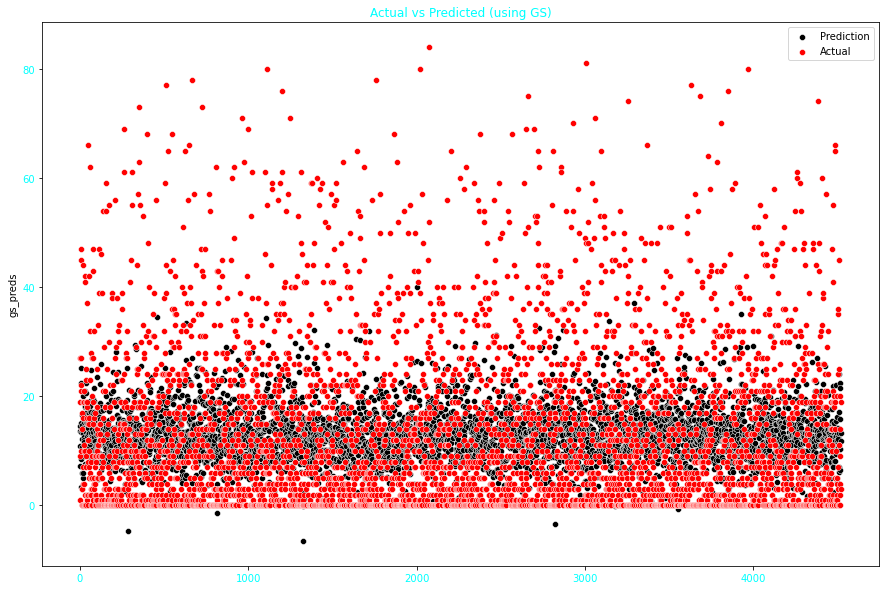

In [428]:
fig, ax = plt.subplots(figsize=(15,10))

preds_df = pd.DataFrame(list(zip(y_test, gs_preds)), columns=["y_test", "gs_preds"])
preds_df["absolute_error"] = preds_df["gs_preds"] - preds_df["y_test"]
preds_df

sns.scatterplot(x=preds_df.index, y="gs_preds", data=preds_df, ax=ax, color="black", label="Prediction")
# plt.plot(y_test - gs_preds, marker='o',linestyle='')
sns.scatterplot(x=preds_df.index, y="y_test", data=preds_df, ax=ax, color="red", label="Actual")

plt.title("Actual vs Predicted (using GS)", color="cyan");
plt.xticks(color="cyan")
plt.yticks(color="cyan");


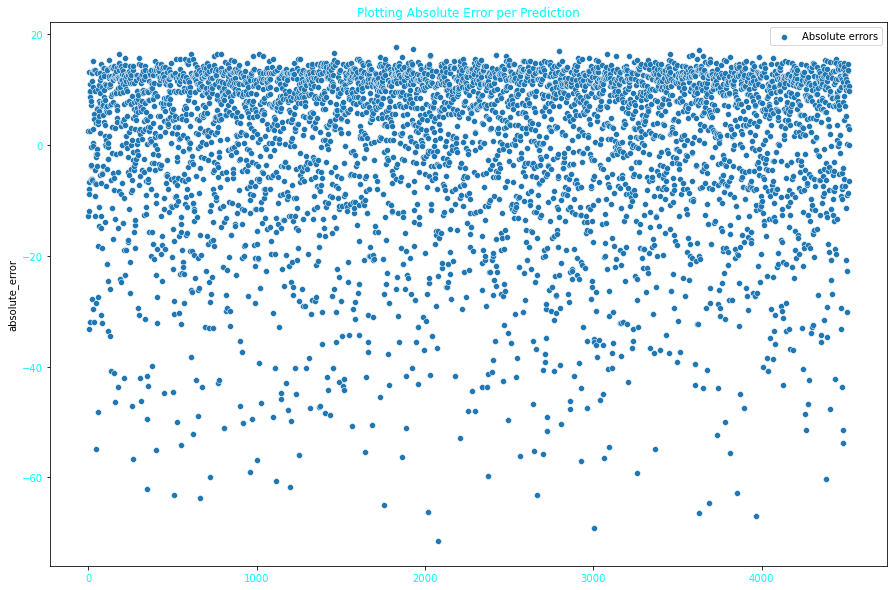

In [382]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=preds_df.index, y="absolute_error", data=preds_df, ax=ax, label="Absolute errors")
plt.title("Plotting Absolute Error per Prediction", color="cyan");
plt.xticks(color="cyan")
plt.yticks(color="cyan");

In [345]:
np.mean(preds_df.y_test)

12.976769911504425

In [397]:
# let's try to stack regressors [not working currently, too slow]
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html
# http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# est1 = XGBRegressor(objective="reg:squarederror", eval_metric="mae",
#                     gamma=0.3, max_depth=2, min_child_weight=5, subsample=1.0)

est1 = SGDRegressor(loss="huber", penalty="l2")
# est2 = DummyRegressor()

est2 = LinearSVR()

est3 = SGDRegressor()

## scaling?

fest = MLPRegressor(activation="relu")

estimators = [('est1', est1), ('est2', est2), ('est3', est3)]

stack = StackingRegressor(estimators=estimators,
                           final_estimator=fest)

## make a pipeline
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', stack)
])

pipe2.fit(X_train, y_train)
pipe2_preds = pipe2.predict(X_test)

pipe2_RMSE = np.sqrt(mean_squared_error(y_test, pipe2_preds))
pipe2_MAE = mean_absolute_error(y_test, pipe2_preds)

print(f'mae: {pipe2_MAE}')
print(f'rmse: {pipe2_RMSE}')
print(f'mse: {mean_squared_error(y_test, pipe2_preds)}')

mae: 11.914104054536345
rmse: 15.190156497856682
mse: 230.74085442937758


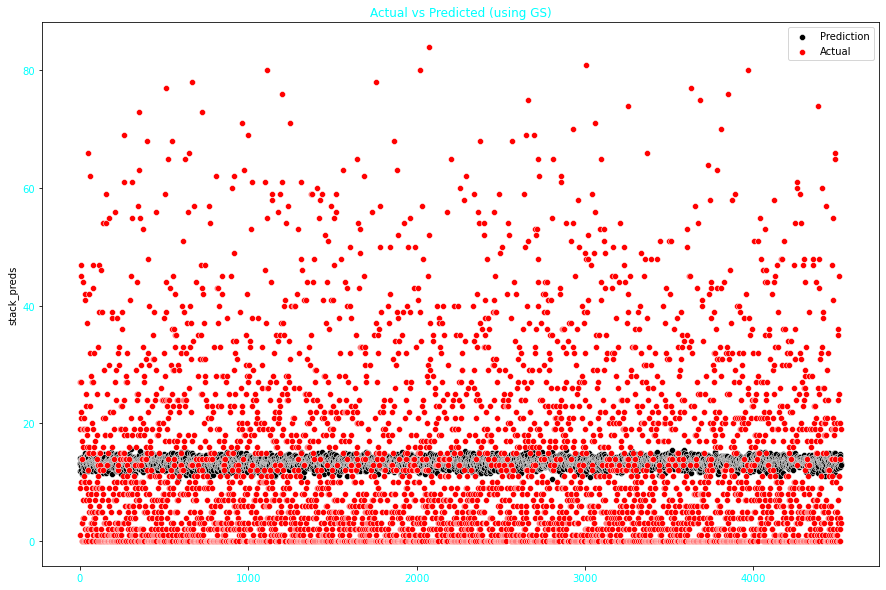

In [398]:
fig, ax = plt.subplots(figsize=(15,10))

preds_df = pd.DataFrame(list(zip(y_test, pipe2_preds)), columns=["y_test", "stack_preds"])
preds_df["absolute_error"] = preds_df["stack_preds"] - preds_df["y_test"]
preds_df

sns.scatterplot(x=preds_df.index, y="stack_preds", data=preds_df, ax=ax, color="black", label="Prediction")
# plt.plot(y_test - gs_preds, marker='o',linestyle='')
sns.scatterplot(x=preds_df.index, y="y_test", data=preds_df, ax=ax, color="red", label="Actual")

plt.title("Actual vs Predicted (using GS)", color="cyan");
plt.xticks(color="cyan")
plt.yticks(color="cyan");

In [67]:

df["Popularity"].describe()

count    8499.000000
mean       13.910813
std        16.118772
min         0.000000
25%         1.000000
50%         8.000000
75%        22.000000
max        78.000000
Name: Popularity, dtype: float64